In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


#### First let's create a baseline model

In [10]:
continuous_cols = df.describe().columns
continuous_cols = continuous_cols[1:]
continuous_var = df[continuous_cols]

cat_cols = ['cntry']
cat_var = pd.get_dummies(df[cat_cols])

features = pd.concat([continuous_var, cat_var], axis=1).drop(columns='partner')
target = df['partner'] - 1

In [12]:
from sklearn.model_selection import train_test_split

X = features
Y = target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=200)

gbc = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=.1, n_estimators=500, max_depth=4)

gbc.fit(X_train, Y_train)

Y_train_preds = gbc.predict(X_train)
Y_test_preds = gbc.predict(X_test)

train_table = pd.crosstab(Y_train, Y_train_preds, margins=True)
test_table = pd.crosstab(Y_test, Y_test_preds, margins=True)

print('Total accuracy for training set: {}'.format((train_table.loc[0.0, 0.0] + train_table.loc[1.0, 1.0])/train_table.loc['All', 'All']))
print('Percentage of type 1 errors: {}'.format(train_table.loc[0.0, 1.0]/train_table.loc['All', 'All']))
print('Percentage of type 2 errors: {}'.format(train_table.loc[1.0, 0.0]/train_table.loc['All', 'All']))
print('--------------------------------')
print('Total accuracy for test set: {}'.format((test_table.loc[0.0, 0.0] + test_table.loc[1.0, 1.0])/test_table.loc['All', 'All']))
print('Percentage of type 1 errors: {}'.format(test_table.loc[0.0, 1.0]/test_table.loc['All', 'All']))
print('Percentage of type 2 errors: {}'.format(test_table.loc[1.0, 0.0]/test_table.loc['All', 'All']))

Total accuracy for training set: 0.8658892128279884
Percentage of type 1 errors: 0.019640939082399878
Percentage of type 2 errors: 0.11446984808961179
--------------------------------
Total accuracy for test set: 0.7484662576687117
Percentage of type 1 errors: 0.07239263803680981
Percentage of type 2 errors: 0.17914110429447852


#### The model seems to be overfit. Let's tune the hyperparameters using GridSearchCV.

In [37]:
from sklearn.model_selection import GridSearchCV

parameters = [{'loss': ['exponential', 'deviance'],
               'learning_rate': [.025, .05, .1],
               'n_estimators': [50, 100, 200],
               'max_depth': [2, 3, 4]}]

grid_search = GridSearchCV(estimator=gbc,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)
grid_search.fit(X_train, Y_train)

print('best params:')
print('-------------')
print(grid_search.best_params_)

best params:
-------------
{'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 100}


#### Let's see what happens after tuning the hyperparemters 

In [38]:
gbc = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=.05, n_estimators=100, max_depth=3)

gbc.fit(X_train, Y_train)

Y_train_preds = gbc.predict(X_train)
Y_test_preds = gbc.predict(X_test)

train_table = pd.crosstab(Y_train, Y_train_preds, margins=True)
test_table = pd.crosstab(Y_test, Y_test_preds, margins=True)

print('Total accuracy for training set: {}'.format((train_table.loc[0.0, 0.0] + train_table.loc[1.0, 1.0])/train_table.loc['All', 'All']))
print('Percentage of type 1 errors: {}'.format(train_table.loc[0.0, 1.0]/train_table.loc['All', 'All']))
print('Percentage of type 2 errors: {}'.format(train_table.loc[1.0, 0.0]/train_table.loc['All', 'All']))
print('--------------------------------')
print('Total accuracy for test set: {}'.format((test_table.loc[0.0, 0.0] + test_table.loc[1.0, 1.0])/test_table.loc['All', 'All']))
print('Percentage of type 1 errors: {}'.format(test_table.loc[0.0, 1.0]/test_table.loc['All', 'All']))
print('Percentage of type 2 errors: {}'.format(test_table.loc[1.0, 0.0]/test_table.loc['All', 'All']))

Total accuracy for training set: 0.7666104035599202
Percentage of type 1 errors: 0.038974988491637254
Percentage of type 2 errors: 0.19441460794844254
--------------------------------
Total accuracy for test set: 0.7613496932515338
Percentage of type 1 errors: 0.044171779141104296
Percentage of type 2 errors: 0.19447852760736195


The model is no longer overfit, and is slightly more accurate. However, there is still more room for improvement in terms of accruacy. Having more useful features in the dataset might help improve the accuracy.
#### Let's look at the relative feature importance

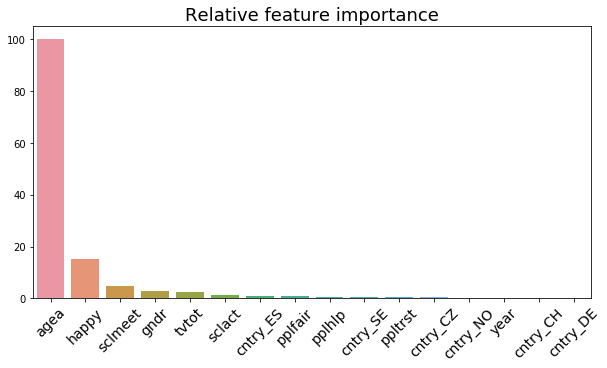

In [81]:
feature_importance = gbc.feature_importances_
feature_importance = 100*feature_importance/feature_importance.max()
feature_importance_dic = {}

i = 0
for col in X.columns:
    feature_importance_dic[col] = feature_importance[i]
    i+=1

feature_importance_dic = sorted(feature_importance_dic.items(), key=lambda x: x[1], reverse=True)

x = [x[0] for x in feature_importance_dic]
y = [x[1] for x in feature_importance_dic]
plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y)
plt.xticks(fontsize=14, rotation=45)
plt.title('Relative feature importance', fontsize=18)
plt.show()

It looks like age is the only useful feature in our data set. I believe having another useful feature would significantly improve our model.